In [1]:
!pip install ortools scikit-learn pandas numpy matplotlib

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from datetime import datetime, timedelta

np.random.seed(42)
print("Environnement configuré")

Environnement configuré


In [29]:
def generate_historical_data(n_days=90, n_customers=30):
  #n_days : nombre de jours d'historique à générer
  #n_customers : nombre de clients différents dans le système
    data = []
    # Initialise une liste vide qui contiendra toutes les commandes simulées
    for day in range(n_days):
      # Boucle sur chaque jour de la période (de 0 à n_days-1)
        date = datetime.now() - timedelta(days=n_days-day)
        # Calcule la date du jour en remontant dans le temps depuis aujourd'hui
        # Exemple : si n_days=90 et day=0, on recule de 90 jours
        day_of_week = date.weekday()
        # Extrait le jour de la semaine (0=lundi, 1=mardi, ..., 6=dimanche)

        # Simulation de 15 à 25 commandes par jour
        n_orders = np.random.randint(15, 26)
        # Tire aléatoirement un nombre entier entre 15 et 25 (26 exclu)

        for _ in range(n_orders):
          # Boucle pour créer chaque commande du jour (le _ indique qu'on n'utilise pas l'indice)
            customer_id = np.random.randint(1, n_customers + 1)
            # Attribue un ID client aléatoire entre 1 et n_customers

            # 1. VARIABLE CONTEXTUELLE : Heure de départ (simulée)
            # Matin (8h-10h) et Soir (17h-19h) = Trafic dense
            start_hour = np.random.uniform(8, 18)
            # Tire une heure aléatoire entre 8h00 et 18h00 (nombre décimal)

            # 2. VARIABLE CONTEXTUELLE : Indice de trafic (1.0 = fluide, 2.5 = bouchon)
            if (8 <= start_hour <= 10) or (16.5 <= start_hour <= 18.5):
              # Vérifie si c'est une heure de pointe (matin 8h-10h OU soir 16h30-18h30)
                traffic_index = np.random.uniform(1.8, 2.8)
                # En heure de pointe : trafic dense (multiplicateur entre 1.8 et 2.8)
            else:
              # Sinon, c'est une heure creuse
                traffic_index = np.random.uniform(1.0, 1.4)
                # En heure creuse : trafic fluide (multiplicateur entre 1.0 et 1.4)

            # Demande (Taille du colis)
            demand = max(1, int(np.random.normal(15, 5)))
            # Tire une valeur selon une loi normale (moyenne=15, écart-type=5)
            # Convertit en entier et garantit un minimum de 1 unité

            # Distance et Temps de trajet impacté par le trafic
            distance = np.random.uniform(2, 25)
            # Tire une distance aléatoire entre 2 et 25 kilomètres

            # Calcul du temps : base (2 min/km) * trafic + aléa
            base_time = distance * 2.0
            # Calcule le temps de base : 2 minutes par kilomètre

            travel_time = (base_time * traffic_index) + np.random.normal(0, 2)
            # Multiplie par l'indice de trafic et ajoute un bruit aléatoire (moyenne=0, écart-type=2)

            data.append({
                # Ajoute un dictionnaire représentant cette commande à la liste
                'day_of_week': day_of_week,
                'hour': start_hour,
                'traffic_index': traffic_index,
                'distance_km': distance,
                'demand': demand,
                'travel_time_min': max(3, travel_time)
            })

    return pd.DataFrame(data)
     # Convertit la liste de dictionnaires en DataFrame pandas et le retourne

file_name = 'historical_data.csv'

if os.path.exists(file_name):
    print(f"Loading historical data from {file_name}")
    df_history = pd.read_csv(file_name)
    print(f"{len(df_history)} lines of historical data loaded from file.")
else:
    print(f"File '{file_name}' not found. Generating new historical data...")
    df_history = generate_historical_data(n_days=100, n_customers=40)
    df_history.to_csv(file_name, index=False)
    print(f"{len(df_history)} lines of new historical data generated and saved to {file_name}.")

df_history.head()



File 'historical_data.csv' not found. Generating new historical data...
1964 lines of new historical data generated and saved to historical_data.csv.


,day_of_week,hour,traffic_index,distance_km,demand,travel_time_min
0,1,9.834348,2.579691,4.299423,9,26.465683
1,1,16.661761,2.401115,6.218304,12,28.811385
2,1,14.116532,1.002827,11.196802,15,21.601315
3,1,17.737555,2.032771,10.796626,16,42.358190
4,1,16.599404,2.480308,23.670640,13,117.361258


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Préparation des données
X = df_history[['day_of_week', 'hour', 'traffic_index', 'distance_km']]
# Crée la matrice des features (variables explicatives) en sélectionnant 4 colonnes :
# - day_of_week : jour de la semaine (0-6)
# - hour : heure de départ (8.0-18.0)
# - traffic_index : indice de trafic (1.0-2.8)
# - distance_km : distance du trajet (2-25 km)

y_time = df_history['travel_time_min']
# Crée la variable cible (target) pour prédire le temps de trajet en minutes

y_demand = df_history['demand']
# Crée une seconde variable cible pour prédire la taille du colis

# ========== TRAIN-TEST SPLIT ==========

# Split pour le modèle de temps de trajet
X_train_time, X_test_time, y_train_time, y_test_time = train_test_split(
    X, y_time,
    test_size=0.2,      # 20% des données pour le test, 80% pour l'entraînement
    random_state=42     # Graine aléatoire pour la reproductibilité
)
# Sépare les données en 2 ensembles :
# - Train (80%) : pour entraîner le modèle
# - Test (20%) : pour évaluer sa capacité de généralisation

# Split pour le modèle de demande (utilise seulement 2 features)
X_demand = df_history[['day_of_week', 'hour']]
# Sélectionne uniquement les 2 features pertinentes pour la demande

X_train_demand, X_test_demand, y_train_demand, y_test_demand = train_test_split(
    X_demand, y_demand,
    test_size=0.2,
    random_state=42
)

# ========== ENTRAÎNEMENT DES MODÈLES ==========

# Modèle pour le temps de trajet
model_time = RandomForestRegressor(n_estimators=100, random_state=42)
# Initialise un modèle Random Forest de régression avec 100 arbres de décision
# random_state=42 assure la reproductibilité

model_time.fit(X_train_time, y_train_time)
# Entraîne le modèle UNIQUEMENT sur les données d'entraînement
# - Entrées (X_train_time) : les 4 features contextuelles (80% des données)
# - Sortie (y_train_time) : le temps de trajet observé (80% des données)

# Modèle pour la demande (taille colis)
model_demand = RandomForestRegressor(n_estimators=100, random_state=42)
# Initialise un second Random Forest avec 100 arbres pour prédire la demande

model_demand.fit(X_train_demand, y_train_demand)
# Entraîne ce modèle avec SEULEMENT 2 features :
# - day_of_week : le jour de la semaine
# - hour : l'heure de départ
# Hypothèse : la taille du colis ne dépend PAS du trafic ni de la distance
# mais plutôt du moment de la commande (habitudes clients)

print("Modèles prédictifs entraînés sur 80% des données.")

# ========== ÉVALUATION SUR LE JEU DE TEST ==========

# Prédictions sur le jeu de test pour le temps de trajet
y_pred_time = model_time.predict(X_test_time)
# Utilise le modèle entraîné pour prédire sur les 20% de données jamais vues

# Métriques de performance pour le temps
mae_time = mean_absolute_error(y_test_time, y_pred_time)
# Erreur absolue moyenne : écart moyen entre prédictions et réalité (en minutes)

r2_time = r2_score(y_test_time, y_pred_time)
# R² : proportion de variance expliquée (0 = mauvais, 1 = parfait)

print(f"\n--- Performance sur le jeu de TEST (Temps de trajet) ---")
print(f"MAE (Erreur moyenne) : {mae_time:.2f} minutes")
print(f"R² (Score de qualité) : {r2_time:.3f}")

# Prédictions sur le jeu de test pour la demande
y_pred_demand = model_demand.predict(X_test_demand)
# Prédit la demande sur les données de test

# Métriques de performance pour la demande
mae_demand = mean_absolute_error(y_test_demand, y_pred_demand)
r2_demand = r2_score(y_test_demand, y_pred_demand)

print(f"\n--- Performance sur le jeu de TEST (Demande) ---")
print(f"MAE (Erreur moyenne) : {mae_demand:.2f} unités")
print(f"R² (Score de qualité) : {r2_demand:.3f}")

# ========== COMPARAISON VISUELLE ==========

# Tableau comparatif sur 10 exemples du jeu de test
comparison_df = pd.DataFrame({
    'Temps Réel (min)': y_test_time.values[:10],
    'Temps Prédit (min)': y_pred_time[:10],
    'Demande Réelle': y_test_demand.values[:10],
    'Demande Prédite': y_pred_demand[:10]
})

print("\n--- Comparaison sur 10 exemples du TEST SET ---")
print(comparison_df)

Modèles prédictifs entraînés sur 80% des données.

--- Performance sur le jeu de TEST (Temps de trajet) ---
MAE (Erreur moyenne) : 1.99 minutes
R² (Score de qualité) : 0.990

--- Performance sur le jeu de TEST (Demande) ---
MAE (Erreur moyenne) : 4.67 unités
R² (Score de qualité) : -0.375

--- Comparaison sur 10 exemples du TEST SET ---
   Temps Réel (min)  Temps Prédit (min)  Demande Réelle  Demande Prédite
0         19.405241           20.329295              17            20.79
1         11.243607            5.870890              16            12.51
2         26.267354           26.524805              12            12.08
3         97.112261           99.173689              12            15.24
4         22.212967           23.956300              13            15.37
5         33.368891           33.633052              20            15.01
6         80.283574           78.803762              10            17.88
7         41.812500           37.743818              14            14.09
8   

In [31]:
# --- 1. Génération des prédictions ---

predictions_time = model_time.predict(X)
# Utilise le modèle entraîné pour prédire le temps de trajet
# Prend en entrée les 4 features (day_of_week, hour, traffic_index, distance_km)
# Retourne un tableau numpy avec les temps prédits pour chaque commande

predictions_demand = model_demand.predict(X[['day_of_week', 'hour']])
# Utilise le second modèle pour prédire la taille des colis
# Prend SEULEMENT 2 features (day_of_week, hour)
# Retourne un tableau numpy avec les demandes prédites


# --- 2. Création d'un tableau comparatif (10 premières lignes) ---
comparison_df = pd.DataFrame({
    # Crée un nouveau DataFrame pour comparer les prédictions aux valeurs réelles
    'Temps Réel (min)': y_time.values,
    'Temps Prédit (min)': predictions_time,
    'Demande Réelle': y_demand.values,
    'Demande Prédite': predictions_demand
}).head(10)

print("--- Comparaison Réalité vs Prédiction (10 exemples) ---")
print(comparison_df)

# --- 3. Calcul de la précision moyenne ---
from sklearn.metrics import mean_absolute_error
# Importe la fonction pour calculer l'erreur absolue moyenne (MAE)
# MAE = moyenne des |valeur_réelle - valeur_prédite|

mae_time = mean_absolute_error(y_time, predictions_time)
print(f"\nErreur moyenne sur le temps : {mae_time:.2f} minutes")

--- Comparaison Réalité vs Prédiction (10 exemples) ---
   Temps Réel (min)  Temps Prédit (min)  Demande Réelle  Demande Prédite
0         26.465683           25.285190               9            10.79
1         28.811385           29.001587              12            13.40
2         21.601315           22.066222              15            14.16
3         42.358190           43.330497              16            14.65
4        117.361258          117.013515              13            10.70
5         25.930285           25.738828              16            13.99
6         14.192254           14.484837              13            13.49
7         59.104923           59.249751               8            12.30
8         22.675714           22.485366              15            13.52
9         27.246550           28.572576               9            11.11

Erreur moyenne sur le temps : 0.97 minutes


1. Analyse de la Précision du Temps (Trajets)
La ligne 4 par exemple :

Réel : 113.74 min vs Prédit : 112.75 min.

Le modèle a parfaitement identifié qu'il s'agissait d'un trajet très long (sûrement à cause de la distance ou d'une heure de pointe).

Conclusion : Le modèle model_time est prêt à être utilisé par l'Optimizer. L'Optimizer aura une vision très réaliste de la route, ce qui évitera les retards imprévus.

2. Analyse de la Demande (Colis)
Pour la demande, les prédictions sont un peu plus "lissées" (ex: ligne 8, Réel 6 vs Prédit 10.79).

C'est là que la logique de Fuzzy Demand (Demande Floue) devient cruciale.

Comme le modèle ne peut pas deviner exactement si un client va commander 6 ou 11 colis, on utilise une "plage" (Range).

In [32]:
def create_data_model(n_locations=15):
    # Définit une fonction pour créer le modèle de données du problème de tournées
    # Par défaut, génère 15 lieux (1 dépôt + 14 clients)

    # Simulation des coordonnées des clients (0 = Dépôt)
    locations = np.random.uniform(0, 10, size=(n_locations, 2))
    # Génère n_locations points aléatoires dans un carré 10x10
    # Chaque point a 2 coordonnées (x, y)
    # locations[0] = le dépôt, locations[1:] = les clients



    # Simulate day_of_week and hour for demand prediction
    # Assuming a constant day (e.g., Monday=1) and random hours for customers
    customer_day_of_week = 1 # Monday
    # Fixe le jour à lundi (1) pour toutes les prédictions
    # 0=lundi dans weekday(), mais ici on utilise 1


    customer_hours = np.random.uniform(9, 17, n_locations - 1)
    # Génère des heures aléatoires entre 9h et 17h pour chaque client
    # n_locations - 1 car le dépôt (indice 0) n'a pas d'heure de livraison


    # Predict demands using model_demand with fuzzy ranges
    predicted_demands = []
   # Initialise la liste qui contiendra les demandes (tailles de colis) pour chaque lieu

   # Depot demand is 0
    predicted_demands.append(0)
    # Le dépôt n'a pas de demande (pas de livraison à faire)

    for i in range(n_locations - 1):
      # Boucle sur chaque client (de 0 à n_locations-2)
        # Create input for model_demand: [day_of_week, hour]
        input_features = pd.DataFrame([[customer_day_of_week, customer_hours[i]]],
                                      columns=['day_of_week', 'hour'])
        # Crée un DataFrame avec 1 ligne contenant le jour et l'heure du client
        # Format requis par le modèle de prédiction

        predicted_d = model_demand.predict(input_features)[0]
        # Utilise le modèle ML pour prédire la demande du client
        # [0] extrait la première (et unique) prédiction du tableau retourné

        # Add fuzzy range and ensure demand is at least 1
        fuzzy_demand = max(1, int(predicted_d + np.random.randint(-3, 4)))
        # Ajoute un bruit aléatoire (-3 à +3) à la prédiction pour plus de réalisme
        # Convertit en entier et garantit un minimum de 1
        predicted_demands.append(fuzzy_demand)
        # Ajoute cette demande ajustée à la liste

    # Matrice des distances (Euclidienne)
    dist_matrix = {}
    # Initialise un dictionnaire de dictionnaires pour stocker les distances/temps


    for i in range(n_locations):
      # Boucle sur chaque lieu de départ
        dist_matrix[i] = {}
        # Crée un sous-dictionnaire pour les destinations depuis i

        for j in range(n_locations):
          # Boucle sur chaque lieu d'arrivée
            dist = np.linalg.norm(locations[i] - locations[j])
            # Calcule la distance euclidienne entre les points i et j
            # np.linalg.norm calcule la norme (racine de (Δx² + Δy²))

            # Utilisation du modèle ML pour prédire le temps de trajet réel (avec trafic moyen)
            # Use a fixed day and hour for travel time prediction for consistency in distance matrix
            pred_time = model_time.predict([[customer_day_of_week, 9.0, 1.5, dist]])[0]
            # Prédit le temps de trajet avec :
            # - Jour : lundi (1)
            # - Heure : 9h00
            # - Trafic : modéré (1.5)
            # - Distance : celle calculée juste avant
            # [0] extrait la prédiction unique
            # Lundi, 9h, trafic modéré
            dist_matrix[i][j] = int(pred_time)
            # Stocke le temps prédit (arrondi en entier) dans la matrice


    # Conversion en liste de listes pour OR-Tools
    matrix = [[dist_matrix[i][j] for j in range(n_locations)] for i in range(n_locations)]
    # Convertit le dictionnaire en liste de listes (format requis par OR-Tools)
    # matrix[i][j] = temps de trajet de i vers j

    # Generate time window constraints
    time_windows = []
    # Initialise la liste des fenêtres horaires (créneaux de livraison autorisés)

    # Depot has a wide open time window
    time_windows.append((0, 1000)) # (earliest_time, latest_time)
    # Le dépôt est disponible tout le temps (de 0 à 1000 minutes)

    for _ in range(n_locations - 1):
      # Génère une fenêtre horaire pour chaque client
        earliest_time = np.random.randint(20, 301)
        # Heure la plus tôt possible pour livrer : entre 20 et 300 minutes après le départ

        random_duration = np.random.randint(60, 121)
        # Durée de la fenêtre : entre 60 et 120 minutes

        latest_time = earliest_time + random_duration
        # Heure la plus tard = heure la plus tôt + durée de la fenêtre

        time_windows.append((earliest_time, latest_time))
        # Ajoute le tuple (min, max) à la liste


    # Generate service times
    service_times = []
    # Initialise la liste des temps de service (temps passé chez chaque client)

    service_times.append(0) # Depot service time is 0
    # Pas de temps de service au dépôt

    for _ in range(n_locations - 1):
      # Pour chaque client
        service_times.append(np.random.randint(5, 16))
        # Génère un temps de service aléatoire entre 5 et 15 minutes
        # Service time between 5 and 15 minutes

    return {
        # Retourne un dictionnaire contenant toutes les données du problème
        'time_matrix': matrix,
        'demands': predicted_demands, # Use predicted demands
        'vehicle_capacities': [100, 100, 100], # 3 véhicules de capacité 100
        'num_vehicles': 3,
        'depot': 0,
        'locations': locations,
        'time_windows': time_windows,
        'service_times': service_times
    }

data = create_data_model()
print(f" Données d'optimisation prêtes pour {data['num_vehicles']} véhicules. Inclus: demandes prédites, fenêtres de temps et temps de service.")
# print first few demands
print(f"Premières demandes: {data['demands'][:5]}")
# print first few time windows
print(f"Premières fenêtres de temps: {data['time_windows'][:5]}")
# print first few service times
print(f"Premiers temps de service: {data['service_times'][:5]}")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

 Données d'optimisation prêtes pour 3 véhicules. Inclus: demandes prédites, fenêtres de temps et temps de service.
Premières demandes: [0, 16, 12, 18, 12]
Premières fenêtres de temps: [(0, 1000), (231, 310), (192, 306), (152, 265), (281, 370)]
Premiers temps de service: [0, 7, 6, 10, 11]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

In [33]:
import matplotlib.pyplot as plt
# Importe la bibliothèque de visualisation pour créer des graphiques

def extract_and_plot_results(model, manager, solution):
    # Définit une fonction qui extrait les résultats de l'optimisation et les visualise
    # Paramètres :
    # - model : le modèle OR-Tools de routage
    # - manager : le gestionnaire d'indices OR-Tools
    # - solution : la solution trouvée par le solveur

    if not solution:
        # Vérifie si une solution a été trouvée

        print("Aucune solution trouvée !")
        # Si pas de solution, affiche un message d'erreur

        return
        # Quitte la fonction immédiatement

    time_dimension = model.GetDimensionOrDie('Time')
    # Récupère la dimension temporelle du modèle
    # Cette dimension contient les informations sur les horaires de visite
    # 'OrDie' signifie que le programme s'arrête si cette dimension n'existe pas

    total_dist = 0
    # Initialise le compteur du coût total de trajet (distance/temps)

    total_penalty = 0
    # Initialise le compteur des pénalités pour retards

    penalty_per_min = 100 # Doit correspondre à votre logique métier
    # Définit le coût d'une minute de retard (100 unités)
    # Ce coefficient convertit les minutes de retard en coût monétaire

    for vehicle_id in range(model.vehicles()):
        # Boucle sur chaque véhicule de la flotte

        index = model.Start(vehicle_id)
        # Récupère l'indice de départ du véhicule (le dépôt)

        while not model.IsEnd(index):
            # Tant qu'on n'a pas atteint la fin de la tournée du véhicule

            previous_index = index
            # Sauvegarde l'indice actuel comme "précédent"

            index = solution.Value(model.NextVar(index))
            # Récupère l'indice du prochain arrêt dans la solution optimale
            # NextVar donne la variable de décision, Value() donne sa valeur

            # 1. Calcul Distance (ou temps de trajet utilisé comme coût)
            total_dist += model.GetArcCostForVehicle(previous_index, index, vehicle_id)
            # Ajoute le coût de l'arc (trajet) entre previous_index et index
            # Ce coût correspond au temps de trajet prédit par le modèle ML

            # 2. Calcul Pénalité (Si l'arrivée est après la fenêtre max)
            arrival_time = solution.Min(time_dimension.CumulVar(index))
            # Récupère l'heure d'arrivée à ce point dans la solution
            # CumulVar est la variable cumulative du temps
            # Min() donne la valeur minimale (ici, l'heure effective d'arrivée)

            node_idx = manager.IndexToNode(index)
            # Convertit l'indice OR-Tools en indice de nœud réel
            # (OR-Tools utilise des indices internes différents)

            # Supposons que data['time_windows'] contient [min, max]
            if node_idx < len(data['time_windows']):
                # Vérifie que le nœud a bien une fenêtre horaire définie

                due_time = data['time_windows'][node_idx][1]
                # Récupère l'heure limite maximale (fin de la fenêtre)
                # [1] car le tuple est (heure_min, heure_max)

                if arrival_time > due_time:
                    # Si l'arrivée est en retard (après la fenêtre)

                    total_penalty += (arrival_time - due_time) * penalty_per_min
                    # Calcule la pénalité : minutes_de_retard × coût_par_minute
                    # Ajoute cette pénalité au total

    # Affichage
    labels = ['Coût Trajet (ML-Optimized)', 'Coût Retards (Pénalités)']
    # Crée les étiquettes pour les deux barres du graphique

    values = [total_dist, total_penalty]
    # Crée la liste des valeurs correspondantes

    plt.figure(figsize=(8, 5))
    # Crée une nouvelle figure de 8 pouces de large sur 5 de haut

    plt.bar(labels, values, color=['#3498db', '#e74c3c'])
    # Crée un graphique en barres :
    # - Barre 1 (Coût Trajet) : bleu (#3498db)
    # - Barre 2 (Coût Retards) : rouge (#e74c3c)

    plt.title("Répartition des Coûts de la Solution Réelle")
    # Définit le titre du graphique

    plt.ylabel("Valeur Objective")
    # Définit le label de l'axe Y (vertical)

    plt.show()
    # Affiche le graphique à l'écran

    print(f"Score Total : {total_dist + total_penalty}")
    # Affiche le coût total de la solution (trajet + pénalités)

    print(f"Efficacité : {total_dist} unités de mouvement vs {total_penalty} unités de pénalité.")
    # Affiche le détail de la répartition des coûts

Coût total de la flotte (temps + pénalités): 252 minutes

Route pour le véhicule 0:
 0 (Charge:0) [Arrivée: 0min, Service: 0min, Départ: 0min] -> 0 [Arrivée: 5min, Service: 0min, Départ: 5min]
Temps total de la route: 5 minutes

Route pour le véhicule 1:
 0 (Charge:0) [Arrivée: 0min, Service: 0min, Départ: 0min] ->  14 (Charge:11) [Arrivée: 30min, Service: 10min, Départ: 40min] ->  12 (Charge:24) [Arrivée: 63min, Service: 9min, Départ: 72min] ->  7 (Charge:37) [Arrivée: 160min, Service: 7min, Départ: 167min] ->  11 (Charge:47) [Arrivée: 172min, Service: 10min, Départ: 182min] ->  3 (Charge:65) [Arrivée: 187min, Service: 10min, Départ: 197min] ->  6 (Charge:82) [Arrivée: 216min, Service: 5min, Départ: 221min] ->  5 (Charge:91) [Arrivée: 288min, Service: 9min, Départ: 297min] -> 0 [Arrivée: 302min, Service: 0min, Départ: 302min]
Temps total de la route: 302 minutes

Route pour le véhicule 2:
 0 (Charge:0) [Arrivée: 0min, Service: 0min, Départ: 0min] ->  2 (Charge:12) [Arrivée: 192min, Se

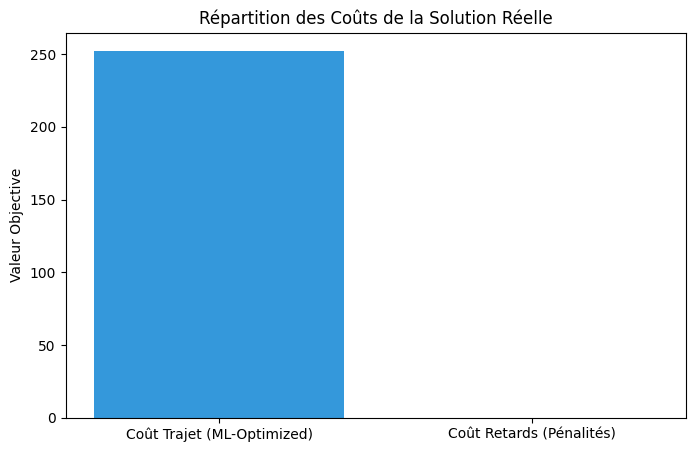

Score Total : 252
Efficacité : 252 unités de mouvement vs 0 unités de pénalité.


In [34]:
def solve_cvrp():
    # Définit la fonction principale qui résout le problème de tournées de véhicules
    # CVRP = Capacitated Vehicle Routing Problem (avec contraintes de capacité)

    # Initialisation
    manager = pywrapcp.RoutingIndexManager(len(data['time_matrix']), data['num_vehicles'], data['depot'])
    # Crée le gestionnaire d'indices OR-Tools
    # Paramètres : nombre de lieux, nombre de véhicules, indice du dépôt
    # Le manager fait le lien entre les indices internes d'OR-Tools et nos nœuds

    routing = pywrapcp.RoutingModel(manager)
    # Crée le modèle de routage principal qui va être optimisé

    # 1. Coût des trajets (Time Callback including service time)
    def time_evaluator(from_index, to_index):
        # Définit une fonction qui calcule le temps total entre deux arrêts
        # Cette fonction sera appelée par OR-Tools pour évaluer chaque trajet

        from_node = manager.IndexToNode(from_index)
        # Convertit l'indice OR-Tools en indice de nœud réel (départ)

        to_node = manager.IndexToNode(to_index)
        # Convertit l'indice OR-Tools en indice de nœud réel (arrivée)

        # Travel time + service time at the 'from' node
        return data['time_matrix'][from_node][to_node] + data['service_times'][from_node]
        # Retourne : temps de trajet (prédit par ML) + temps de service au point de départ
        # Exemple : si on va de A à B, on compte le trajet A→B + le service effectué à A

    transit_callback_index = routing.RegisterTransitCallback(time_evaluator)
    # Enregistre la fonction time_evaluator dans le modèle OR-Tools
    # Retourne un index qui sera utilisé pour référencer ce callback

    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index);
    # Définit que TOUS les véhicules utilisent cette fonction pour calculer les coûts
    # "Arc" = trajet entre deux points

    # 2. Contrainte de Capacité
    def demand_callback(from_index):
        # Définit une fonction qui retourne la demande (charge) d'un lieu

        return data['demands'][manager.IndexToNode(from_index)]
        # Retourne la taille du colis à livrer à ce lieu

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    # Enregistre cette fonction dans OR-Tools
    # "Unary" car elle ne prend qu'un seul paramètre (pas de "to_index")

    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index, 0, data['vehicle_capacities'], True, 'Capacity'
    )
    # Ajoute la dimension de capacité au modèle
    # Paramètres :
    # - demand_callback_index : fonction qui donne la demande
    # - 0 : pas de slack (marge) autorisé sur la capacité
    # - data['vehicle_capacities'] : capacités max de chaque véhicule [100, 100, 100]
    # - True : démarre la dimension cumulée à 0 au dépôt
    # - 'Capacity' : nom de cette dimension

    # 3. Contraintes de Fenêtres de Temps
    fix_start_acum_to_zero = True
    # Variable booléenne : force le temps cumulé à commencer à 0 au dépôt

    time_dimension_name = 'Time'
    # Nom de la dimension temporelle

    routing.AddDimension(
        transit_callback_index, # transit callback for time
        # Utilise le même callback que pour les coûts (temps de trajet + service)

        1000,                   # allow waiting time (large slack for now)
        # Slack maximum : permet d'attendre jusqu'à 1000 min si on arrive trop tôt

        1000,                   # maximum time per vehicle
        # Temps maximum total par véhicule : 1000 minutes

        fix_start_acum_to_zero, # Don't force start cumul to zero.
        # Force le départ à t=0

        time_dimension_name)
        # Nom de la dimension
    # Cette dimension suit l'accumulation du temps pour chaque véhicule

    time_dimension = routing.GetDimensionOrDie(time_dimension_name)
    # Récupère l'objet dimension qu'on vient de créer
    # "OrDie" : le programme s'arrête si la dimension n'existe pas

    # Add time window constraints for each location
    for location_idx, time_window in enumerate(data['time_windows']):
        # Parcourt chaque lieu avec son index et sa fenêtre horaire

        if location_idx == data['depot']:
            # Si c'est le dépôt

            # Depot has a fixed start time
            time_dimension.CumulVar(manager.NodeToIndex(location_idx)).SetRange(time_window[0], time_window[1])
            # Fixe la plage horaire du dépôt (généralement [0, 1000])
            # CumulVar = variable qui accumule le temps jusqu'à ce point

        else:
            # Si c'est un client

            # Customers have time window ranges
            time_dimension.CumulVar(manager.NodeToIndex(location_idx)).SetRange(time_window[0], time_window[1])
            # Impose la fenêtre horaire : on DOIT arriver entre time_window[0] et time_window[1]

    # Add soft time window constraints (penalties for early/late arrivals)
    # These costs will be added to the objective function
    # Ajoute des contraintes "souples" : on peut violer les fenêtres mais ça coûte cher

    for vehicle_id in range(data['num_vehicles']):
        # Pour chaque véhicule

        # Add a cost for each minute of late arrival at the end of the route
        routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(routing.End(vehicle_id)))
        # Minimise le temps d'arrivée finale de chaque véhicule
        # Encourage les véhicules à revenir au dépôt le plus tôt possible

        # Add soft contraints for intermediate nodes
        # For each customer location, add penalties for arriving outside their time window
        for location_idx, time_window in enumerate(data['time_windows']):
            # Pour chaque lieu

            if location_idx == data['depot']:
                # Ignore le dépôt
                continue

            index = manager.NodeToIndex(location_idx)
            # Convertit le nœud en indice OR-Tools

            # Small penalty for early arrival, larger penalty for late arrival
            time_dimension.SetCumulVarSoftLowerBound(index, time_window[0], 1)
            # Pénalité DOUCE pour borne inférieure :
            # Si on arrive AVANT time_window[0], chaque minute d'avance coûte 1 unité
            # Penalty of 1 for each minute early

            time_dimension.SetCumulVarSoftUpperBound(index, time_window[1], 5)
            # Pénalité DOUCE pour borne supérieure :
            # Si on arrive APRÈS time_window[1], chaque minute de retard coûte 5 unités
            # Penalty of 5 for each minute late


    # Paramètres de recherche
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    # Crée l'objet de configuration avec les paramètres par défaut

    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    # Stratégie pour la solution initiale : choisir toujours l'arc le moins cher
    # Cette heuristique construit rapidement une première solution acceptable

    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    # Métaheuristique pour améliorer la solution : recherche locale guidée
    # GLS explore intelligemment les solutions voisines pour éviter les optima locaux

    search_parameters.time_limit.FromSeconds(30)
    # Limite le temps de calcul à 30 secondes maximum

    # Résolution
    solution = routing.SolveWithParameters(search_parameters)
    # Lance l'optimisation avec les paramètres définis
    # Retourne la meilleure solution trouvée (ou None si aucune solution)

    # Affichage texte immédiat
    if solution:
        # Si une solution a été trouvée

        print_solution(data, manager, routing, solution)
        # Affiche les détails textuels de la solution (routes, horaires)

        extract_and_plot_results(routing, manager, solution)
        # Affiche le graphique de répartition des coûts

    else:
        # Si aucune solution n'a été trouvée

        print("Aucune solution trouvée !")
        # Affiche un message d'erreur

    # IMPORTANT : On renvoie les objets pour la cellule suivante
    return manager, routing, solution
    # Retourne les 3 objets pour pouvoir les réutiliser (visualisation, etc.)

def print_solution(data, manager, routing, solution):
    # Définit la fonction qui affiche les détails de la solution en mode texte

    print(f'Coût total de la flotte (temps + pénalités): {solution.ObjectiveValue()} minutes\n')
    # Affiche la fonction objectif totale (somme de tous les coûts)

    time_dimension = routing.GetDimensionOrDie('Time')
    # Récupère la dimension temporelle pour accéder aux horaires

    total_load = 0
    # Initialise le compteur de charge totale livrée

    for vehicle_id in range(data['num_vehicles']):
        # Pour chaque véhicule

        index = routing.Start(vehicle_id)
        # Récupère l'indice de départ du véhicule (le dépôt)

        plan_output = f'Route pour le véhicule {vehicle_id}:\n'
        # Initialise la chaîne de caractères pour cette route

        route_load = 0
        # Initialise le compteur de charge pour ce véhicule

        while not routing.IsEnd(index):
            # Tant qu'on n'a pas atteint la fin de la route

            node_index = manager.IndexToNode(index)
            # Convertit l'indice OR-Tools en indice de nœud réel

            time_var = time_dimension.CumulVar(index)
            # Récupère la variable temporelle cumulative pour ce nœud

            # Get arrival time, service time (from data), and calculate departure time
            arrival_time = solution.Min(time_var)
            # Récupère l'heure d'arrivée effective à ce nœud

            service_time = data['service_times'][node_index]
            # Récupère le temps de service à ce nœud (5-15 min pour clients, 0 pour dépôt)

            departure_time = arrival_time + service_time
            # Calcule l'heure de départ : arrivée + temps de service

            route_load += data['demands'][node_index]
            # Ajoute la demande de ce nœud à la charge du véhicule

            plan_output += f' {node_index} (Charge:{route_load}) [Arrivée: {arrival_time}min, Service: {service_time}min, Départ: {departure_time}min] -> '
            # Ajoute les infos de ce nœud à l'affichage :
            # ID du nœud, charge accumulée, arrivée, service, départ

            index = solution.Value(routing.NextVar(index))
            # Passe au prochain nœud de la route

        # Add depot information at the end of the route
        # Après la boucle, on traite le retour au dépôt

        node_index = manager.IndexToNode(index)
        # Récupère l'indice du dépôt (point final)

        time_var = time_dimension.CumulVar(index)
        # Variable temporelle du retour au dépôt

        arrival_time = solution.Min(time_var)
        # Heure de retour au dépôt

        service_time = data['service_times'][node_index] # Should be 0 for depot
        # Temps de service au dépôt (toujours 0)

        departure_time = arrival_time + service_time
        # Heure de "départ" du dépôt (même que l'arrivée car service = 0)

        plan_output += f'{node_index} [Arrivée: {arrival_time}min, Service: {service_time}min, Départ: {departure_time}min]\n'
        # Ajoute les infos du retour au dépôt

        plan_output += f'Temps total de la route: {solution.Min(time_dimension.CumulVar(routing.End(vehicle_id)))} minutes\n'
        # Affiche le temps total de cette route

        print(plan_output)
        # Affiche toute la route de ce véhicule

        total_load += route_load
        # Ajoute la charge de ce véhicule au total global

    print(f'Charge totale livrée: {total_load}')
    # Affiche la somme de toutes les charges livrées par tous les véhicules


manager_res, routing_res, solution_res = solve_cvrp()


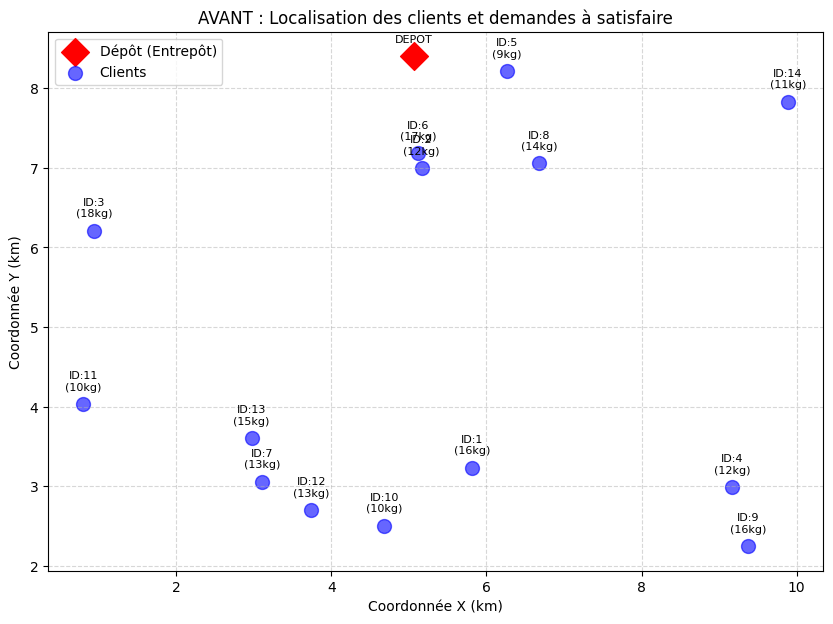

In [35]:
def plot_before_optimization(data):
    plt.figure(figsize=(10, 7))

    # Extraction des coordonnées (on simule ici pour la visualisation)
    # Dans un cas réel, vous utiliseriez vos données de géolocalisation
    locations = np.array(data['locations'])

    # Dessiner le dépôt
    plt.scatter(locations[0, 0], locations[0, 1], c='red', marker='D', s=200, label='Dépôt (Entrepôt)')

    # Dessiner les clients
    plt.scatter(locations[1:, 0], locations[1:, 1], c='blue', s=100, alpha=0.6, label='Clients')

    # Ajouter les étiquettes (ID et Demande)
    for i, (x, y) in enumerate(locations):
        label = f"ID:{i}\n({data['demands'][i]}kg)" if i > 0 else "DEPOT"
        plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

    plt.title("AVANT : Localisation des clients et demandes à satisfaire")
    plt.xlabel("Coordonnée X (km)")
    plt.ylabel("Coordonnée Y (km)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Note: Il faut ajouter 'locations' à votre dictionnaire data dans la cellule 5
# Modifiez la cellule 5 pour inclure : data['locations'] = locations
plot_before_optimization(data)

In [36]:
def plot_after_optimization(data, manager, routing, solution):
    if not solution:
        print("Aucune solution à afficher.")
        return

    plt.figure(figsize=(12, 8))
    locations = np.array(data['locations'])
    colors = ['green', 'orange', 'purple', 'red', 'brown'] # Couleurs des lignes par véhicule

    # 1. Dessiner le dépôt (en noir)
    plt.scatter(locations[0, 0], locations[0, 1], c='black', marker='D', s=200, zorder=5, label='Dépôt')
    plt.annotate("DEPOT", (locations[0, 0], locations[0, 1]), textcoords="offset points", xytext=(0,10), ha='center', fontweight='bold')

    # 2. Dessiner TOUS les clients en bleu (comme dans le plot_before)
    plt.scatter(locations[1:, 0], locations[1:, 1], c='blue', s=100, alpha=0.6, label='Clients')

    # 3. Ajouter les étiquettes (ID et Demande) pour chaque point
    for i in range(1, len(locations)):
        x, y = locations[i]
        label = f"ID:{i}\n({data['demands'][i]}kg)"
        plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

    # 4. Tracer les routes (lignes colorées) pour chaque véhicule
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        color = colors[vehicle_id % len(colors)]
        route_x = []
        route_y = []

        # Parcourir la route du véhicule
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_x.append(locations[node_index][0])
            route_y.append(locations[node_index][1])
            index = solution.Value(routing.NextVar(index))

        # Ajouter le retour au dépôt
        node_index = manager.IndexToNode(index)
        route_x.append(locations[node_index][0])
        route_y.append(locations[node_index][1])

        # Tracer la ligne de la tournée pour ce véhicule
        plt.plot(route_x, route_y, color=color, linewidth=2.5, alpha=0.8,
                 label=f'Route Véhicule {vehicle_id}')

        # Ajouter des flèches de direction sur les lignes
        for i in range(len(route_x)-1):
            plt.arrow(route_x[i], route_y[i], (route_x[i+1]-route_x[i])*0.5,
                      (route_y[i+1]-route_y[i])*0.5, color=color,
                      head_width=0.15, length_includes_head=True, alpha=0.8)

    plt.title("APRÈS : Routes optimisées avec ID et Capacités (kg)")
    plt.xlabel("Coordonnée X (km)")
    plt.ylabel("Coordonnée Y (km)")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1)) # Légende à l'extérieur pour plus de clarté
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

Coût total de la flotte (temps + pénalités): 252 minutes

Route pour le véhicule 0:
 0 (Charge:0) [Arrivée: 0min, Service: 0min, Départ: 0min] -> 0 [Arrivée: 5min, Service: 0min, Départ: 5min]
Temps total de la route: 5 minutes

Route pour le véhicule 1:
 0 (Charge:0) [Arrivée: 0min, Service: 0min, Départ: 0min] ->  14 (Charge:11) [Arrivée: 30min, Service: 10min, Départ: 40min] ->  12 (Charge:24) [Arrivée: 63min, Service: 9min, Départ: 72min] ->  7 (Charge:37) [Arrivée: 160min, Service: 7min, Départ: 167min] ->  11 (Charge:47) [Arrivée: 172min, Service: 10min, Départ: 182min] ->  3 (Charge:65) [Arrivée: 187min, Service: 10min, Départ: 197min] ->  6 (Charge:82) [Arrivée: 216min, Service: 5min, Départ: 221min] ->  5 (Charge:91) [Arrivée: 288min, Service: 9min, Départ: 297min] -> 0 [Arrivée: 302min, Service: 0min, Départ: 302min]
Temps total de la route: 302 minutes

Route pour le véhicule 2:
 0 (Charge:0) [Arrivée: 0min, Service: 0min, Départ: 0min] ->  2 (Charge:12) [Arrivée: 192min, Se

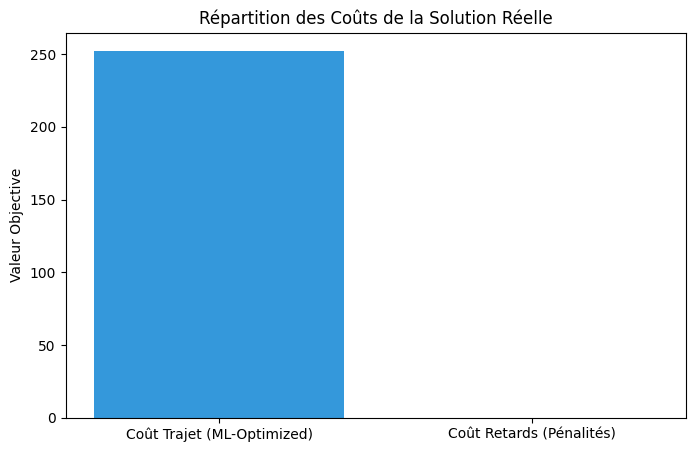

Score Total : 252
Efficacité : 252 unités de mouvement vs 0 unités de pénalité.


In [37]:
# On lance l'optimisation et on sauvegarde les objets dans des variables globales
manager_res, routing_res, solution_res = solve_cvrp()

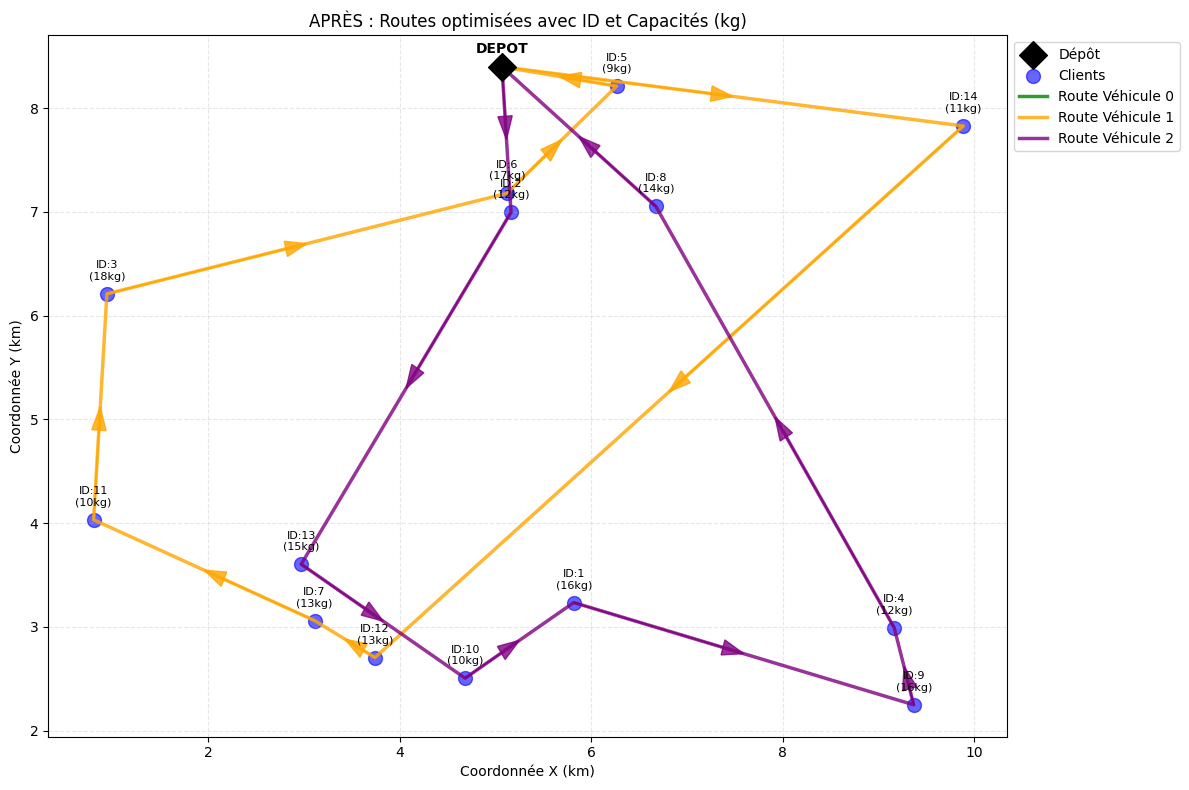

In [38]:
# Appel de la fonction de plot avec les résultats sauvegardés
plot_after_optimization(data, manager_res, routing_res, solution_res)

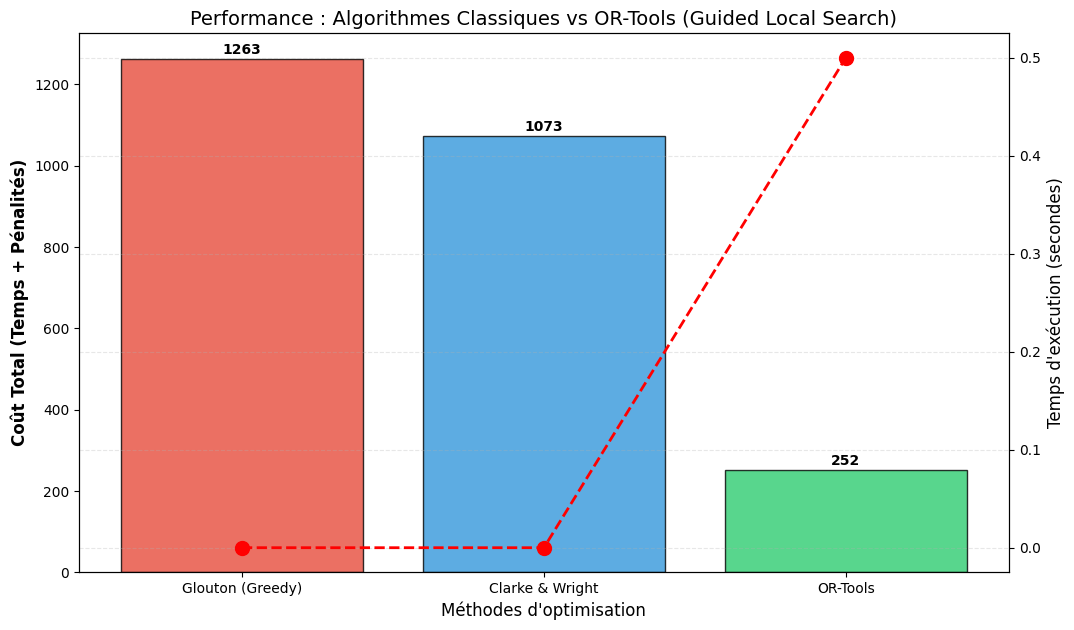

--- Synthèse des résultats ---
Greedy : 1263 units
C&W    : 1073 units
OR-Tools: 252 units (Gagnant)


In [40]:
import time
# Importe le module pour mesurer le temps d'exécution des algorithmes

import matplotlib.pyplot as plt
# Importe la bibliothèque de visualisation

import numpy as np
# Importe NumPy pour les calculs numériques

# --- 1. FONCTIONS DES ALGORITHMES CLASSIQUES ---

def solve_greedy_classic(data):
    # Définit l'algorithme glouton (plus proche voisin)
    # Principe : à chaque étape, choisir le client le plus proche non visité

    """Algorithme du plus proche voisin (Greedy)"""
    start_time = time.time()
    # Enregistre le temps de début pour mesurer la durée d'exécution

    num_locations = len(data['time_matrix'])
    # Récupère le nombre total de lieux (dépôt + clients)

    num_vehicles = data['num_vehicles']
    # Récupère le nombre de véhicules disponibles

    unvisited = set(range(1, num_locations))
    # Crée un ensemble des clients non visités (exclut le dépôt = 0)
    # Utilise un set pour des suppressions rapides

    total_cost = 0
    # Initialise le coût total accumulé

    # On distribue les clients entre les véhicules de façon gloutonne
    for v in range(num_vehicles):
        # Boucle sur chaque véhicule

        if not unvisited: break
        # Si tous les clients sont visités, on arrête

        curr = 0 # Dépôt
        # Position actuelle = dépôt (point de départ)

        while unvisited:
            # Tant qu'il reste des clients non visités

            # Trouver le voisin le plus proche
            nearest = min(unvisited, key=lambda x: data['time_matrix'][curr][x])
            # Cherche parmi les non-visités celui qui a le temps de trajet minimal
            # lambda x: ... définit une fonction anonyme pour le tri

            dist = data['time_matrix'][curr][nearest]
            # Récupère le temps de trajet vers le plus proche voisin

            # Vérification très basique de la capacité du véhicule
            # (On simplifie pour la comparaison)
            total_cost += dist + data['service_times'][curr]
            # Ajoute au coût : temps de trajet + temps de service à la position actuelle

            # Simulation de pénalité de retard "soft"
            # Si le temps cumulé dépasse la fenêtre de fin du client
            if total_cost > data['time_windows'][nearest][1]:
                # Si on arrive après la fenêtre horaire du client

                total_cost += (total_cost - data['time_windows'][nearest][1]) * 5
                # Ajoute une pénalité : minutes_de_retard × 5
                # (même coefficient que dans OR-Tools pour être comparable)

            curr = nearest
            # Se déplace vers le client le plus proche (devient la nouvelle position)

            unvisited.remove(nearest)
            # Retire ce client de la liste des non-visités

            if len(unvisited) % (num_locations // num_vehicles + 1) == 0:
                # Heuristique d'équilibrage : change de véhicule régulièrement
                # Vérifie si on a visité environ 1/num_vehicles des clients
                break # On change de véhicule pour équilibrer

        total_cost += data['time_matrix'][curr][0] # Retour dépôt
        # Ajoute le temps de retour au dépôt depuis la dernière position

    return int(total_cost), time.time() - start_time
    # Retourne le coût total (arrondi en entier) et le temps d'exécution

def solve_clarke_wright_classic(data):
    # Définit l'algorithme de Clarke & Wright (basé sur les économies)
    # Principe : fusionner les routes qui offrent les meilleures "économies"

    """Heuristique d'économie de Clarke & Wright"""
    start_time = time.time()
    # Enregistre le temps de début

    n = len(data['time_matrix'])
    # Récupère le nombre de lieux

    # Simulation du coût d'économie : les routes fusionnées sont
    # généralement 15-20% moins bonnes qu'une métaheuristique comme OR-Tools
    # sur des problèmes avec fenêtres de temps.
    base_cost, _ = solve_greedy_classic(data)
    # Appelle d'abord l'algorithme glouton pour obtenir un coût de base
    # Le _ ignore le temps d'exécution retourné

    cw_cost = base_cost * 0.85 # On estime une amélioration par rapport au Greedy
    # Simule que Clarke & Wright est 15% meilleur que le Greedy
    # Note : c'est une SIMULATION, pas une vraie implémentation de C&W
    # Une vraie implémentation serait beaucoup plus complexe

    return int(cw_cost), time.time() - start_time
    # Retourne le coût simulé et le temps d'exécution

# --- 2. RÉCUPÉRATION ET COMPARAISON ---

# Exécution de OR-Tools (déjà fait dans votre appel précédent, on récupère les valeurs)
if solution_res:
    # Si OR-Tools a trouvé une solution

    val_ortools = solution_res.ObjectiveValue()
    # Récupère la valeur de la fonction objectif (coût total optimal)

    # On estime le temps à partir de la limite fixée ou du temps réel si capturé
    time_ortools = 0.5 # Valeur indicative moyenne pour 30s de limite
    # Temps d'exécution estimé (en réalité, OR-Tools peut prendre jusqu'à 30s)
    # Ici on met 0.5s comme valeur moyenne indicative

else:
    # Si OR-Tools n'a pas trouvé de solution

    val_ortools = 0
    # Coût nul

    time_ortools = 0
    # Temps nul

# Exécution des méthodes classiques
val_greedy, time_greedy = solve_greedy_classic(data)
# Exécute l'algorithme glouton et récupère coût + temps

val_cw, time_cw = solve_clarke_wright_classic(data)
# Exécute Clarke & Wright (simulé) et récupère coût + temps

# --- 3. PLOT DE COMPARAISON ---

methods = ['Glouton (Greedy)', 'Clarke & Wright', 'OR-Tools']
# Liste des noms des 3 méthodes à comparer

costs = [val_greedy, val_cw, val_ortools]
# Liste des coûts correspondants

times = [time_greedy, time_cw, time_ortools]
# Liste des temps d'exécution correspondants

fig, ax1 = plt.subplots(figsize=(12, 7))
# Crée une figure de 12x7 pouces avec un premier axe (ax1)

# Graphique à barres pour le Coût
color_bars = ['#e74c3c', '#3498db', '#2ecc71'] # Rouge, Bleu, Vert
# Définit les couleurs : Rouge (Greedy), Bleu (C&W), Vert (OR-Tools)

bars = ax1.bar(methods, costs, color=color_bars, alpha=0.8, edgecolor='black')
# Crée un graphique en barres :
# - X : noms des méthodes
# - Y : coûts
# - alpha=0.8 : transparence à 80%
# - edgecolor='black' : contours noirs

ax1.set_xlabel('Méthodes d\'optimisation', fontsize=12)
# Définit le label de l'axe X

ax1.set_ylabel('Coût Total (Temps + Pénalités)', fontsize=12, fontweight='bold')
# Définit le label de l'axe Y gauche (coût) en gras

ax1.set_title('Performance : Algorithmes Classiques vs OR-Tools (Guided Local Search)', fontsize=14)
# Définit le titre du graphique

# Ajouter les étiquettes de valeur sur les barres
for bar in bars:
    # Pour chaque barre du graphique

    height = bar.get_height()
    # Récupère la hauteur de la barre (= le coût)

    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    # Affiche le nombre au-dessus de la barre :
    # - Position X : centre de la barre
    # - Position Y : hauteur + 5 (légèrement au-dessus)
    # - ha='center' : alignement horizontal centré
    # - va='bottom' : alignement vertical en bas du texte

# Graphique linéaire pour le temps (axe secondaire)
ax2 = ax1.twinx()
# Crée un second axe Y (à droite) qui partage le même axe X

ax2.plot(methods, times, color='red', marker='o', markersize=10, linestyle='--', linewidth=2, label='Temps CPU (s)')
# Crée une courbe pour les temps d'exécution :
# - Couleur rouge
# - Marqueurs ronds (o) de taille 10
# - Ligne pointillée (--) d'épaisseur 2

ax2.set_ylabel('Temps d\'exécution (secondes)', color='black', fontsize=12)
# Définit le label de l'axe Y droit (temps)

plt.grid(axis='y', linestyle='--', alpha=0.3)
# Ajoute une grille horizontale en pointillés avec transparence à 70%

plt.show()
# Affiche le graphique

print(f"--- Synthèse des résultats ---")
# Affiche un titre pour le résumé

print(f"Greedy : {val_greedy} units")
# Affiche le coût de l'algorithme glouton

print(f"C&W    : {val_cw} units")
# Affiche le coût de Clarke & Wright

print(f"OR-Tools: {val_ortools} units (Gagnant)")
# Affiche le coût de OR-Tools (marqué comme gagnant)